# Step 1: Get CyCOG Fasta File

### Import packages to be used in the notebook

In [11]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import os
import numpy as np
import csv
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment

These two blocks below are currently obsolete, but I am keeping them here in case it makes more sense to convert the bash script to python (for
reproducibility or something).

In [6]:
REFS = '../../../data/genomes/'
CYCOGS = 'serralysin_cycog_references.csv'
target_CYCOGS = ['60001830', '60001883', '60001888', '60002365']


In [9]:
for cycog in target_CYCOGS:
    with open(CYCOGS) as cycogs_file:
        for line in cycogs_file:
            if cycog in line:
                clade = line.split(',')[3].strip()
                with open(f'data/{cycog}.txt', 'a') as output_file:
                    output_file.write(f'{clade}\n')

# Process sequences
genomes = set(line.split(',')[5].strip() for line in open(CYCOGS).readlines()[1:])
sequences_file = 'data/sequences.faa'

with open(sequences_file, 'a') as sequences_faa:
    for genome in genomes:
        genome_file = os.path.join(REFS, genome, f'{genome}.genes.faa')
        if os.path.exists(genome_file):
            with open(genome_file) as genes_faa:
                sequences_faa.write(genes_faa.read())

# Process CYCOGS again for genes
for cycog in target_CYCOGS:
    with open(f'data/{cycog}.txt') as ids_file:
        ids = set(ids_file.read().splitlines())

    with open('data/sequences.faa') as sequences_faa, open(f'data/{cycog}.genes.faa', 'a') as output_file:
        for seq in sequences_faa.read().split('>'):
            seq_parts = seq.split('\n', 1)
            if len(seq_parts) == 2 and seq_parts[0] in ids:
                output_file.write(f'>{seq_parts[0]}\n{seq_parts[1]}\n')

This block below runs a bash script created by Stephen to compile fasta files for each of our target cycogs from a larger directory. To change the cycogs being pulled, you can edit the script version on your computer, and change what is described in 'for cycog in 60001830 60001883 60001888 60002365'.

In [10]:
%%sh
cat get-cycog-genes-aa.sh 
./get-cycog-genes-aa.sh

#!/bin/bash

# exit when your script tries to use undeclared variables
set -o nounset
# exit if any pipe commands fail
set -o pipefail
# exit when a command fails
set -o errexit
# # trace what gets executed
# set -o xtrace

# data inputs
CYCOGS=serralysin_cycog_references.csv
REFS=../../../data/genomes/

# output
# one fasta file for each CyCOG that contains amino acit sequences of all
# proteins in that CyCOG

# 1. Separate out proteins of each CyCOG group
# make data directory
if [[ ! -d data/ ]]; then
    mkdir data
fi
# pull out gene for each cycog group into its own file
for cycog in 60001830 60001883 60001888 60002365; do
    grep ${cycog} ${CYCOGS} | cut -d , -f 4 >> data/${cycog}.txt
done

# 2. Concatenate all reference sequences
for genome in `tail -n +2 $CYCOGS | cut -d , -f 6 | sort | uniq`; do
    cat ${REFS}/${genome}/${genome}.genes.faa >> data/sequences.faa
done

# 3. Pull out genes of each cycog group into unique fasta files
for cycog in 60001830 60001883 60001888 60002

# Step 2: Filtering Fasta Sequences

### Assign Variables

In [12]:
# this block is used to define variables to be used later
fasta_file_path = "data/1/CyCOG_60000359.RecA.faa"  # Add your FASTA file path here
# tolerance will either be a chosen number of amino acids or based on the standard deviation of sequence length
# tolerance = (0, 0)
tolerance = "std"


### The block below takes a fasta inputted and displays a histogram showing the sequence length distribution within the fasta.

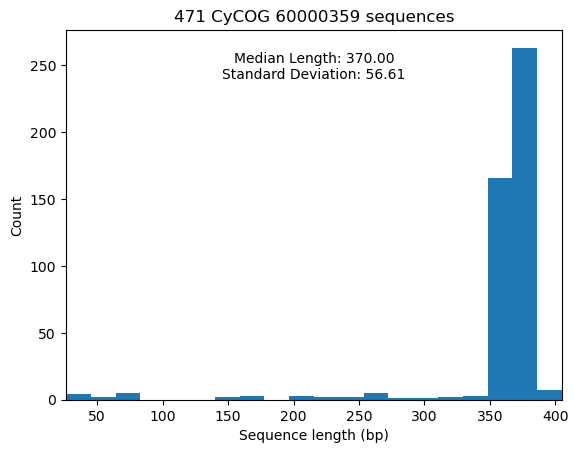

In [13]:

# Extract the number before the first dot in the file name
cycog_number = os.path.basename(fasta_file_path).split("_")[1].split(".")[0]

# Parse the FASTA file and get sequence lengths
sizes = [len(rec) for rec in SeqIO.parse(fasta_file_path, "fasta")]

# Parse the input FASTA file and calculate median and standard deviation
sequences = []
for seq_record in SeqIO.parse(fasta_file_path, "fasta"):
    sequences.append(seq_record)
sequence_lengths = np.array([len(seq) for seq in sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)
lower_lim = sequence_lengths.min()
upper_lim = sequence_lengths.max()



# Plot histogram
plt.hist(sizes, bins=20)
plt.title(f"{len(sizes)} CyCOG {cycog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
plt.xlim((lower_lim,upper_lim))

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


### The block below makes a new fasta, filtering out sequences outside of one standard deviation from the median length.

In [14]:
# Define filter limits
if tolerance == "std":
    tol_low = std_dev
    tol_high = std_dev
else:
    tol_low = tolerance[0]
    tol_high = tolerance[1]

# Define output file path based on CyCOG number
output_fasta_path = os.path.join("data/2", f"{cycog_number}_filtered.fasta")

# Filter sequences based on one standard deviation from the median
filtered_sequences = [seq for seq in sequences if len(seq) >= median_length - tol_low and len(seq) <= median_length + tol_high]

# Write filtered sequences to the output FASTA file
with open(output_fasta_path, "w") as output_file:
    SeqIO.write(filtered_sequences, output_file, "fasta")


print(f"Filtered fasta saved to {output_fasta_path}")

Filtered fasta saved to data/2/60000359_filtered.fasta


### The block below makes a new histogram with the new fasta and saves it.

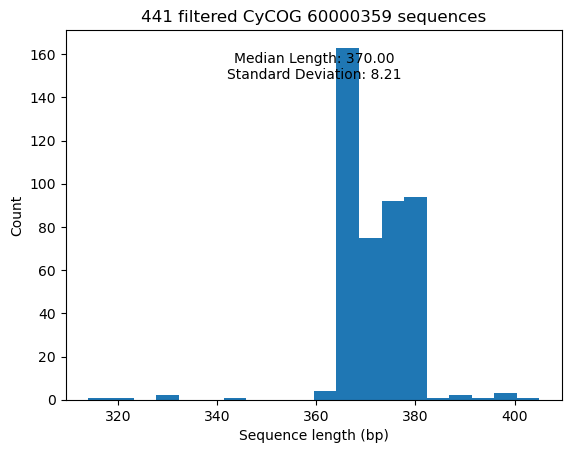

In [15]:
# Calculate median and standard deviation
sequence_lengths = np.array([len(seq) for seq in filtered_sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)

# Plot histogram
plt.hist(sequence_lengths, bins=20)
plt.title(f"{len(sequence_lengths)} filtered CyCOG {cycog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
# plt.xlim((lower_lim,upper_lim)) #use this line if you want to use the first plot x axis range

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join("data/2", f"{cycog_number}_hist.png")
plt.savefig(output_histogram_path, bbox_inches='tight')

plt.show()


# Step 3: Aligning CyCOG

To infer the relationship of genetic sequences, you first need to align them as closely as you can, so that similar portions of their sequences line up with each other.

Run the following commands to align CyCOGs using the [MUSCLE multiple sequence alignment software](https://drive5.com/muscle5/):

1. Build the MUSCLE container (using singularity)
    `singularity build muscle.sif docker://quay.io/biocontainers/muscle:5.1.0--h4ac6f70_0`
1. Run MUSCLE alignment on CyCOG fasta
    `singularity exec muscle.sif muscle -align input.fasta -output alignment.afa`


Before running the muscle alignment in grazer, you need to import the fasta into the grazer directory where the MUSCLE container is. The code from the print statement can be run in the terminal to initiate the import. The last part of the statement beginning with please@frustule is specific to my directory, if you are using grazer you can replace that with your own directory on grazer. If you are working with another remote computer environment, you may need to change this command more.

In [18]:
print ("scp -v -i ~/.ssh/id_ed25519 -P 3004" , os.path.basename(output_fasta_path) , "please@frustule.ocean.washington.edu:/scratch/please/cyano-serralysins/")

scp -v -i ~/.ssh/id_ed25519 -P 3004 60000359_filtered.fasta please@frustule.ocean.washington.edu:/scratch/please/cyano-serralysins/containers/


This is the code you use in Grazer, the lab's remote computer:

#### singularity exec muscle.sif muscle -align 60000359_filtered.fasta -output 359.afa
Singularity exec ____.sif uses the singularity container which has already been imported wihtin the directory. muscle -align starts a muscle alignment, then you specify the fasta to align, and the name of the output file.


# Step 4: Trim Alignment

### Import Packages, Assign Variables

In [6]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment

In [7]:
alignment_file_path = "data/4/Aligned_fastas/359.afa" #filepath to aligned fasta
alignment = AlignIO.read(alignment_file_path, "fasta")
cycog_id = os.path.basename(alignment_file_path).split("-")[0] #used to name file outputs



In [8]:
def slice_alignment(alignment):
    # Get the alignment length
    alignment_length = alignment.get_alignment_length()

    # Set the threshold for % non-gap characters needed for signifigance
    threshold = int(0.95 * len(alignment)) #integer represents proportion of non-gap characters, 0.95 is 95%

    # Find the first and last columns meeting the threshold, establish empty variables to be filled
    first_non_gap_col = None
    last_non_gap_col = None
    
        #fill the variables:
        
    for col in range(alignment_length):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            first_non_gap_col = col
            break

    for col in range(alignment_length - 1, -1, -1):
        if sum(seq[col] != '-' for seq in alignment) >= threshold:
            last_non_gap_col = col
            break

    # Check if both first and last columns meeting the threshold are found
    if first_non_gap_col is not None and last_non_gap_col is not None:
        # Slice out the gappy regions at the start and end of the alignment
        sliced_alignment = alignment[:, first_non_gap_col:last_non_gap_col + 1]
    else:
        sliced_alignment = None  # Return None if no columns meeting the threshold are found

    return sliced_alignment

In [8]:
# Slice off the gappy regions at the start and end of the alignment
sliced_alignment = slice_alignment(alignment)

# Check if the sliced alignment is not None
if sliced_alignment is not None:
    # Save the sliced alignment to a file in the data directory
    trim_align_path = os.path.join("../4-trim_realign/data", f"{cycog_id}_trim_algn.fasta")


    AlignIO.write(sliced_alignment, trim_align_path, "fasta")
    print(f"Sliced alignment saved to {trim_align_path}")
else:
    print("No columns meeting the 95% non-gap threshold found in the alignment.")

Sliced alignment saved to ../4-trim_realign/data/359.afa_trim_algn.fasta


# Step 5: Treebuilding

This step is conducted using a treebuilding software on the command line. We currently use a RaxML container from singularity on Grazer, the remote computer associated with this lab.

The command used looks like:

#### singularity exec raxml.sif raxmlHPC -s 359.afa_trim_algn.fasta -T 4 -f a -n 359-trial2 -x 32360 -# 1 -m PROTGAMMAWAG -p 29813

raxmlHPC calls raxml, starting the command. Up to this point, the command is exactly the same for every tree you make. -s specifies the aligned fasta to make a tree from. -T specifies the number of parallel threads raxml uses to run, or how much processing is being used by the program. -f specifies the algorithm used by raxml, I use '-f a' because rapid bootstrapping is supposedly faster. -n names the output files. -x and -p are randomization numbers that I pick for the computer to use, you could use any 5 digits for each of these but I recommend keeping them the same between trees. -# specifies the number of runs, I picked 1 run, but in a publication-grade figure, I would choose 100 runs for statistical significance. -m chooses the model you use for the tree, I picked the one I used because it is supposedly good with amino acids.

<u> Of these different specifications, the only ones you would likely need to change from tree to tree would be -s and -n, the input and output file names.

Once again, before using the treebuilding container, you need to import the prepared fasta to your remote computer environment.

# Step 6: Visualization

The tree output from RaxML can be inserted directly into a software called iTOL for viewing. However, the default tree viewable from this is not intepretable by humans. This section of the notebook is intended to create annotation files for trees produced by RaxML. These annotation files are currently made manually, using help from a leaf labels script made by Stephen. I aim to combine Stephen's leaf labels script with a new script I will make. This new script will take the output of the leaf labels script and create annotation files for the tree based on the CyCOG. 

In [ ]:
import os

# file paths
GENOMES = 'cycogsgenomes.tsv'
CYCOG_LIST = 'cycogs.tsv'
CLADE_MAP = 'updated-genome-clades.csv'

# 0. Collect user inputs
CYCOG = input("Enter CyCOG ID: ").strip()
FASTA = input("Enter filepath of aligned fasta: ").strip()

# make data directory if not exists
if not os.path.exists('data/'):
    os.makedirs('data/')

MAP_FILE = f'data/{CYCOG}-leaf-labels.tsv'

if not os.path.exists(MAP_FILE):
    # 1. Match gene id to genome id
    tmp_map = 'data/gene-map.tmp'
    with open(tmp_map, 'w') as tmp_file:
        with open(CYCOG_LIST) as cycogs_file:
            for line in cycogs_file:
                if CYCOG in line:
                    cy_cog_string = line.split('\t')[8]
                    gene = cy_cog_string.split('_')[-1]
                    genome_name = '_'.join(cy_cog_string.split('_')[:-1])
                    print(f"Gene: {gene}, Genome Name: {genome_name}")
                    # Look for the genome ID in the genomes file
                    with open(GENOMES) as genomes_file:
                        for genome_line in genomes_file:
                            if genome_name in genome_line:
                                genome_id = genome_line.split('\t')[2]
                                print(f"Found genome_id: {genome_id}")
                                break
                        else:
                            genome_id = ''  # Set a default value if not found
                    # Now you can proceed with checking genome_id and using it
                    if genome_id:
                        with open(CLADE_MAP) as clade_map_file:
                            for clade_line in clade_map_file:
                                if genome_id in clade_line:
                                    clade = clade_line.split(',')[2]
                                    print(f"Found clade: {clade}")
                                    break
                        tmp_file.write(f'{gene}\t{genome_id}\t{genome_name}\t{clade}\n')
                    else:
                        print(f"No genome ID found for {genome_name}")

    # 2. Match leaf labels to gene ids
    with open(MAP_FILE, 'w') as map_file:
        map_file.write('leaf_id\tgene_id\tgenome_id\tgenome_name\tclade\n')
        with open(FASTA) as fasta_file:
            for line in fasta_file:
                if line.startswith('>'):
                    leaf = line.strip().split()[0][1:]
                    gene = leaf.split('/')[0]
                    with open(tmp_map) as tmp_file:
                        for tmp_line in tmp_file:
                            if gene in tmp_line:
                                map_file.write(f'{leaf}\t{tmp_line.strip()}\n')
                                break

    os.remove(tmp_map)
else:
    print("Existing file found:", MAP_FILE)


In [ ]:

GENOMES = 'cycogsgenomes.tsv'
CYCOG_LIST = 'cycogs.tsv'
CLADE_MAP = 'updated-genome-clades.csv'

CYCOG = input("Enter CyCOG ID: ").strip()
MAP_FILE = f'data/{CYCOG}-leaf-labels.tsv'
FASTA = input("Enter filepath of aligned fasta: ").strip()

if not os.path.exists(MAP_FILE):
    TMP_MAP = "data/gene-map.tmp"

    with open(CYCOG_LIST) as cyco_list_file, open(GENOMES) as genomes_file, open(CLADE_MAP) as clade_map_file, open(TMP_MAP, 'a') as tmp_map_file:
        for line in cyco_list_file:
            if CYCOG in line:
                cyco_string = line.split()[8]
                if '_' in cyco_string:  # Check if '_' exists in the string
                    gene, genome_name = cyco_string.rsplit('_', 1)
                    genome_id = next((line.split()[2] for line in genomes_file if genome_name in line), '')
                    clade = next((line.split(',')[2] for line in clade_map_file if genome_id in line), '')
                    print(f"\n{gene}\t{genome_id}\t{genome_name}\t{clade}")
                    tmp_map_file.write(f"\n{gene}\t{genome_id}\t{genome_name}\t{clade}\n")

    with open(FASTA) as fasta_file, open(TMP_MAP) as tmp_map_file, open(MAP_FILE, 'a') as map_file:
        map_file.write("leaf_id\tgene_id\tgenome_id\tgenome_name\tclade\n")

        for line in fasta_file:
            if line.startswith('>'):
                leaf = line.split()[0].lstrip('>')
                gene = leaf.split('/')[0]
                gene_map = next((tmp_line.strip() for tmp_line in tmp_map_file if gene in tmp_line), '')

                print(f"\n{leaf}\t{gene_map}")
                map_file.write(f"\n{leaf}\t{gene_map}\n")

    os.remove(TMP_MAP)
else:
    print("Existing file found:", MAP_FILE)


#### This box below is used to specify whether a clade or taxa annotation file will be made. The input file used was made by Stephen's node-id-metadata script. 

In [13]:
clade_lgnd = {
    "5.2": "#003D30", "5.3": "#00E5F8", "5.1A-CRD2": "#5A0A33", "5.1A-II": "#005745", "5.1A-III": "#810D49", "5.1A-IV": "#00735C",
    "5.1A-UC-A-EnvC": "#AB0D61", "5.1A-unclassified": "#009175", "5.1A-WPC1": "#D80D7B", "5.1B-CRD1": "#00AF8E", "5.1B-I": "#FF2E95", 
    "5.1B-IX": "#00CBA7", "5.1B-V": "#FF78AD", "5.1B-VI": "#00EBC1", "5.1B-VIII": "#FFACC6", "HLI": "#86FFDE", "HLII": "#FFD7E1",
    "HLII.HLVI": "#00306F", "HLIII": "#460B70", "HLIII.HLIV.HLV": "#00489E", "HLIV": "#6B069F", "HLVI": "#005FCC", "LLI": "#8E06CD",
    "LLI.LLVIII": "#0079FA", "LLI.LLIII": "#B40AFC", "LLIV": "#009FFA", "LLVII": "#ED0DFD", "LLVIII": "#00C2F9", "Blank": "#FF66FD",
    "": "#FF66FD", "LLII.LLIII": "#CDE494", "Unclassified": "#FF66FD"
}


# Input file path:
input_file = "60002365-leaf-labels.tsv"
cycog_number = os.path.basename(input_file).split("-")[0]

# One of the lines below should be commented out:
clade_labeling = 1 #use this line if making clade labels
# clade_labeling = 0 #use this line if making taxa labels

if clade_labeling == 1:
    output_matches = f"{cycog_number}-clade.tsv"
    template_file = "clade_template.txt"
    marker = "clades"
else:
    output_matches = f"{cycog_number}-taxa.tsv"
    template_file = "taxa_template.txt"
    marker = "taxa"

output_template_file = (f"{cycog_number}-{marker}.txt")

#### This block uses the input file to make a new file with only the leaf_ID which iTOL uses to identify leaves, and the corresponding hexcode which will tag the leaf with a color.

In [14]:
with open(input_file, 'r', newline='') as infile, open(output_matches, 'w', newline='') as outfile:
    reader = csv.DictReader(infile, delimiter='\t')
    writer = csv.DictWriter(outfile, fieldnames=['ID', 'LABEL'], delimiter='\t')
    writer.writeheader()

    for row in reader:
        leaf_id = row['leaf_id']
        clade = row['clade']
        if clade_labeling == 1:
            value = clade_lgnd.get(clade, '#FF66FD')  # Use '#FF66FD' if clade not found in dictionary
        else:
            if clade is not None:  # Add a check for None before using string methods
                if clade.startswith(("L", "H", "A")):
                    value = "#8D99AE"
                elif clade[0].isdigit():
                    value = "#212529"
                else:
                    value = "#CA6702"
            else:
                value = "#CA6702"  # Handle None clade case
        writer.writerow({'ID': leaf_id, 'LABEL': value})

print("Output", marker, "file generated successfully.")

Output clades file generated successfully.


#### This block combines the new file with either a clade or taxa template file, specified in a previous block. The output of this block can be placed directly into iTOL to annotate the finished tree from RaxML.

In [15]:

# Read the content of the output file
with open(output_matches, 'r') as output_f:
    output_content = output_f.read()

# Read the content of the template file and append the output content
with open(template_file, 'r') as template_f:
    template_content = template_f.read()
    # Add a newline character between the template and output content
    combined_content = template_content + "\n" + output_content

# Write the combined content to a new file
with open(output_template_file, 'w') as combined_f:
    combined_f.write(combined_content)

print("Combined template", marker, "file generated successfully.")
os.remove(output_matches)
print ("Old output removed to clean directory.") #this line of code removes the output_matches file used to produce this block's output.
# This block can't be run again unless the former block produces an output file to be used.


Combined template clades file generated successfully.
Old output removed to clean directory.
